In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import os, sys, math, random
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
from torchvision.utils import save_image
from tqdm.notebook import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt
from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
from pytorch3d.utils import ico_sphere
from src.gan import Discriminator, Generator
from src.training import weights_init_normal
from src.notebook_utils import imshow, imgrid
from pytorch3d.io import load_objs_as_meshes

In [35]:
batch_size = 50
img_size = 128
latent_size = 100
adversarial_loss = torch.nn.BCELoss()

In [39]:
generator = Generator(batch_size, latent_size, img_size).cuda()
discriminator = Discriminator(img_size).cuda()

In [40]:
valid = torch.ones((batch_size, 1), requires_grad=False).cuda()
fake = torch.zeros((batch_size, 1), requires_grad=False).cuda()

In [41]:
# generator.renderer_silhouette.cuda()

In [42]:
z = torch.randn(batch_size, latent_size).cuda()
gen_meshes, gen_imgs = generator(z)

In [43]:
def draw_tensor(tensor, nmax=20):
    images = (np.clip(tensor.detach().cpu().numpy(), 0, 1) * 255).astype('uint8')
    imshow(imgrid(images[:nmax]))

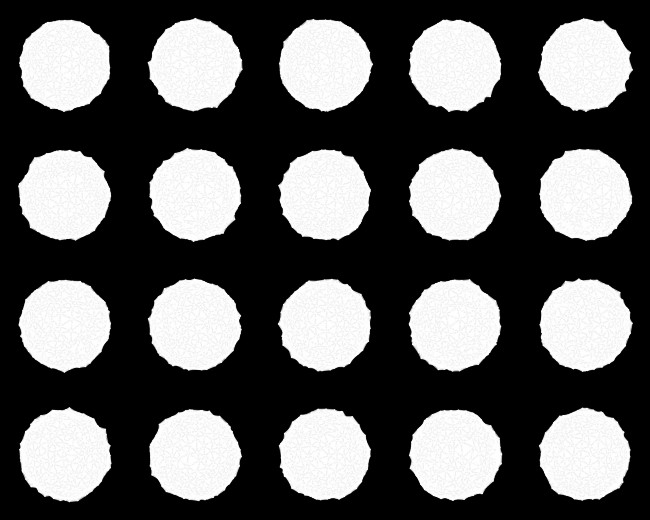

In [44]:
draw_tensor(gen_imgs)

In [45]:
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLOrthographicCameras,
    OpenGLPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    SoftSilhouetteShader,
    SoftPhongShader,
    TexturesVertex
)
device = torch.device("cuda:0")
DATA_DIR = "./data"
obj_filename = os.path.join(DATA_DIR, "cow_mesh/cow.obj")
mesh = load_objs_as_meshes([obj_filename], device=device)
verts = mesh.verts_packed()
N = verts.shape[0]
center = verts.mean(0)
scale = max((verts - center).abs().max(0)[0])
mesh.offset_verts_(-center.expand(N, 3))
mesh.scale_verts_((1.0 / float(scale)))

In [46]:
meshes = mesh.extend(20)

In [47]:
# Rasterization settings for silhouette rendering  
sigma = 1e-4
raster_settings_silhouette = RasterizationSettings(
    image_size=128, 
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma, 
    faces_per_pixel=50, 
)

# Silhouette renderer 
renderer_silhouette = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=None, 
        raster_settings=raster_settings_silhouette
    ),
    shader=SoftSilhouetteShader()
)

lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

def random_target_images(meshes):
    n = len(meshes)
    elev = torch.FloatTensor(n).uniform_(0, 0)
    #azim = torch.FloatTensor(n).uniform_(-180, 180)
    r = 60
    azim = torch.FloatTensor(n).uniform_(180-r, 180+r)
#     azim = torch.FloatTensor(n).uniform_(170, 190)
    R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)
    cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)
    silhouette_images = renderer_silhouette(meshes, cameras=cameras, lights=lights)
    return silhouette_images[:, :, :, -1]

In [14]:
dataset = np.vstack([
    random_target_images(meshes).detach().cpu().numpy()
    for _ in tqdm(range(2000))
])

In [15]:
target_hand_silhouette = np.load('./data/hand_silhouettes.npy')
target_hand_silhouette = target_hand_silhouette.astype('float32') / 255
target_hand_silhouette = torch.tensor(target_hand_silhouette).cuda()

In [16]:
# dataset = np.vstack(dataset)
# print(dataset.shape)

In [17]:
# draw_tensor(random_target_images(meshes))

In [48]:
def get_batch(n = batch_size):
#     n = target_hand_silhouette.shape[0]
    n = dataset.shape[0]
    indices = torch.randperm(n)[:batch_size]
    
#     indices = torch.zeros(n, dtype=int)
    return torch.tensor(dataset[indices])


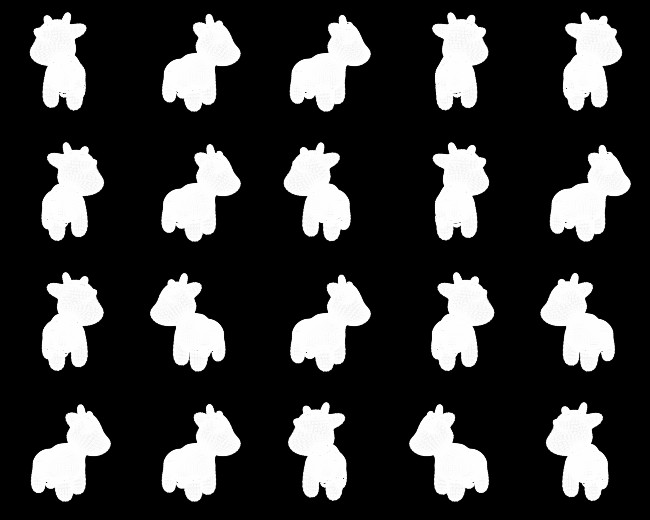

In [49]:
draw_tensor(get_batch()[:20])

In [50]:
def mesh_loss(mesh):
    loss = .1 * mesh_normal_consistency(mesh)
    loss += 1 * mesh_edge_loss(mesh)
    loss += mesh_laplacian_smoothing(mesh, method="uniform")
    return loss

In [70]:
lr = .0002 / 10
betas = (.5, .999)

generator = Generator(batch_size, latent_size, img_size).cuda()
discriminator = Discriminator(img_size).cuda()

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=betas)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=betas)
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)


None

In [71]:
# gen_imgs.min()

In [72]:
losses = []
def train(epoch):
    total_g_loss = 0
    total_d_loss = 0
    loop = tqdm(range(20))
    
    for batch_idx in loop:
        #  Train Generator
        optimizer_G.zero_grad()
        z = torch.randn(batch_size, latent_size).cuda()
        
        gen_mesh, gen_imgs = generator(z)
        
        gen_imgs = gen_imgs.unsqueeze(1)
        gen_imgs = (gen_imgs * 2) - 1
        
        ml = torch.zeros(1).cuda()
#         ml = 200 * mesh_loss(gen_mesh)
        g_loss = ml + adversarial_loss(discriminator(gen_imgs), valid)
        
        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()
        
        real_imgs = get_batch().unsqueeze(1).cuda()
        real_imgs = (real_imgs * 2) - 1
        
        #print(gen_imgs.min(), gen_imgs.max())
        #print(real_imgs.min(), real_imgs.max())
        
        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
        total_g_loss += g_loss.item()
        total_d_loss += d_loss.item()
        
        loop.set_description(f'ml={ml.item():.4f}; gl={g_loss.item():.4f} dl={d_loss.item():.4f}')
        losses.append([ml.item(), g_loss.item(), d_loss.item()])
    
    print(epoch, total_g_loss / batch_size,  total_d_loss / batch_size)

# test_n = 100
# test_z = torch.randn(test_n, latent_size).cuda()
def display_test():
    test_z = torch.randn(batch_size, latent_size).cuda()
    _, gen_imgs = generator(test_z)
    draw_tensor(gen_imgs)


0 0.8583435785770416 0.08222991175949573


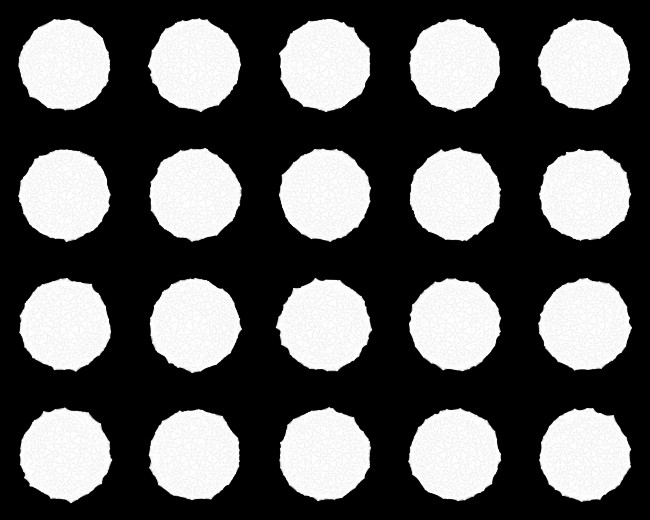


1 1.6077561378479004 0.008115596938878297


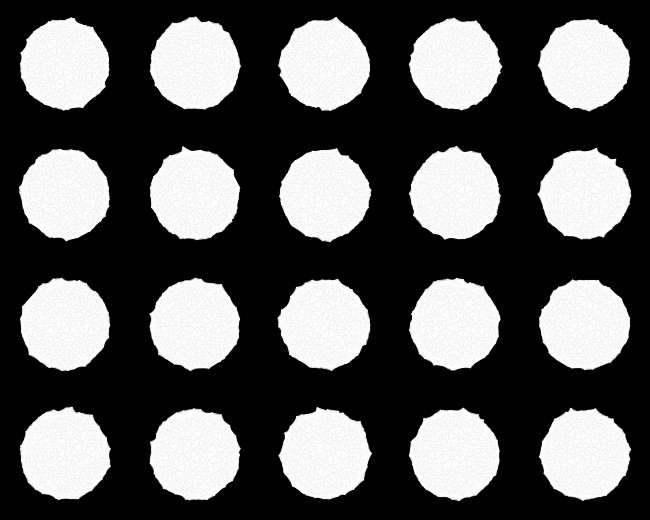


2 1.945537700653076 0.003325921092182398


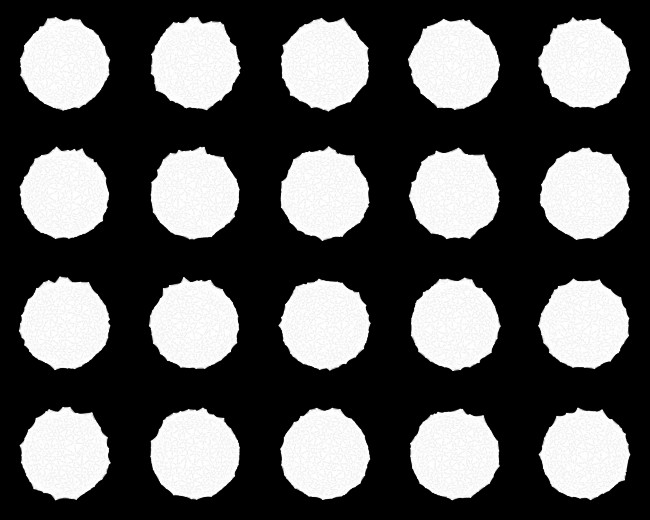


3 2.149718246459961 0.0019680805690586566


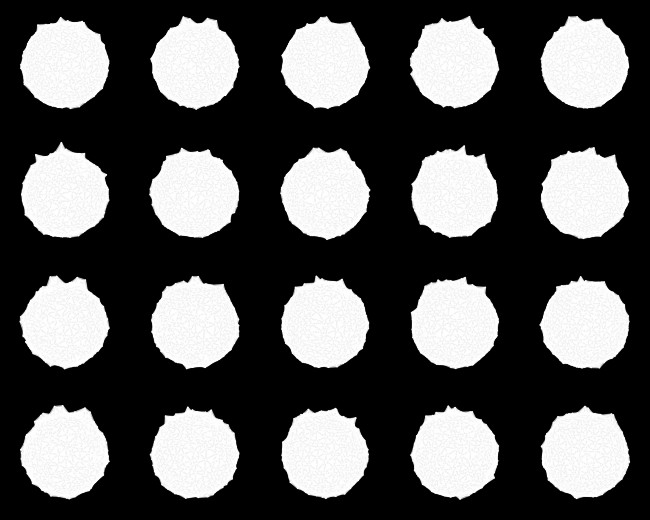


4 2.265357780456543 0.0014981796219944955


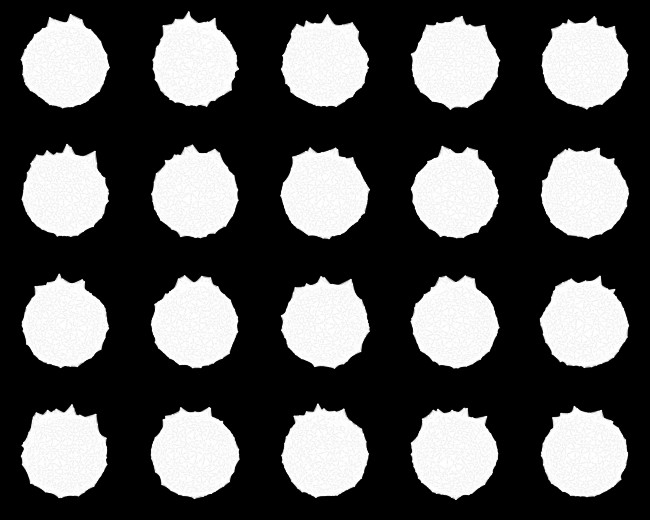


5 2.3355930709838866 0.001339517207816243


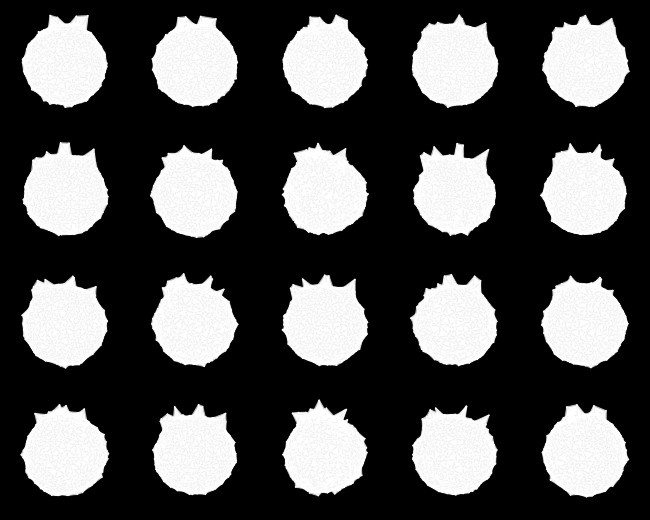


6 2.4029636192321777 0.0012917905487120152


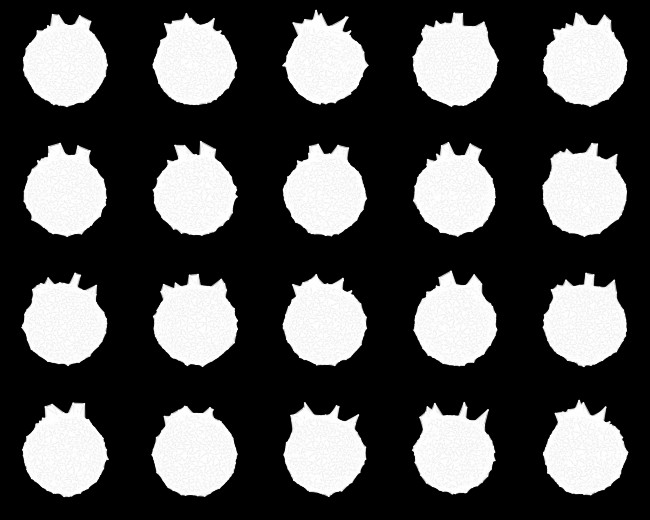


7 2.478080739974976 0.0013154985383152962


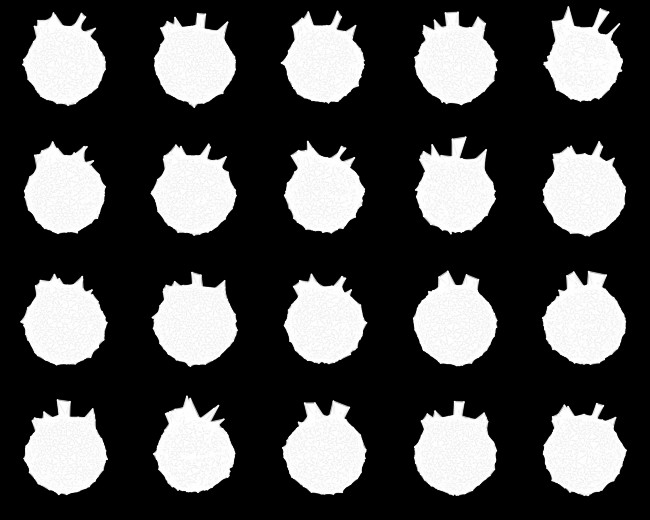


8 2.651499662399292 0.0014731136010959745


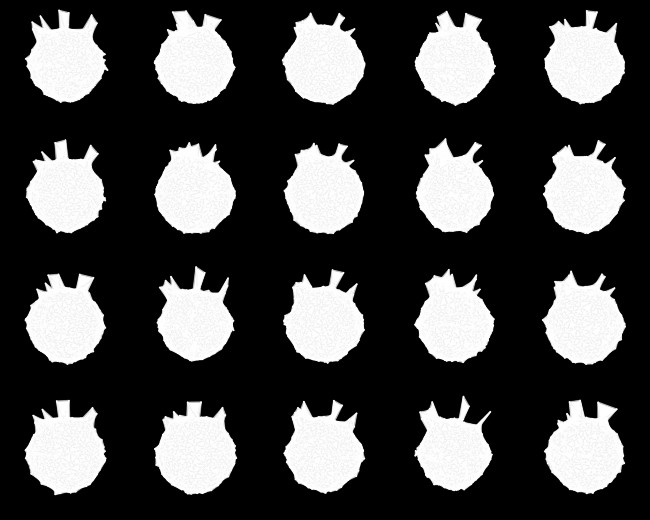


9 2.821042184829712 0.001437440230511129


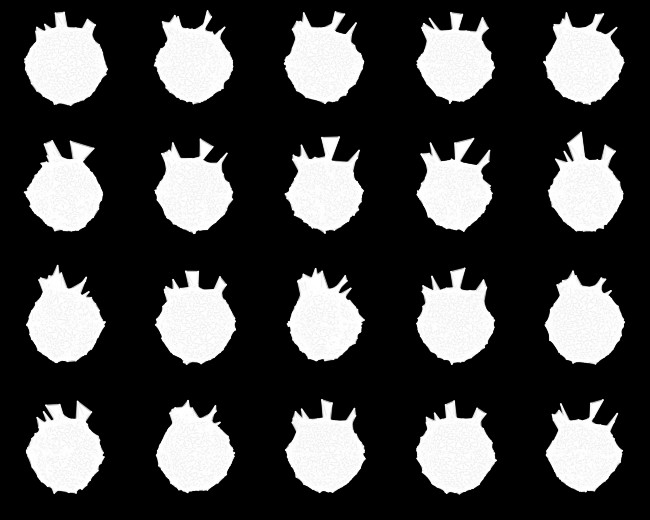


10 3.064857769012451 0.0020803668489679694


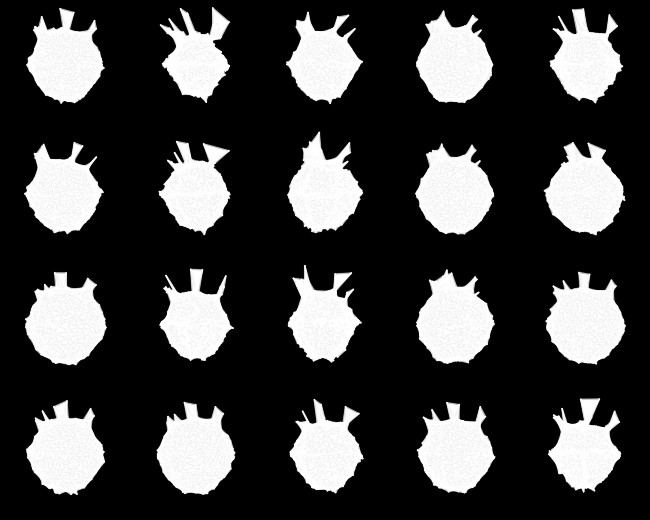


11 3.3881468868255613 0.001998247243463993


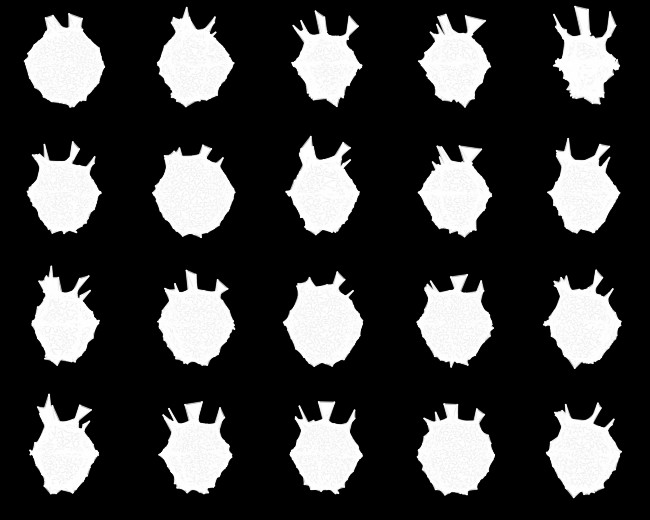


12 3.458288803100586 0.00924068057909608


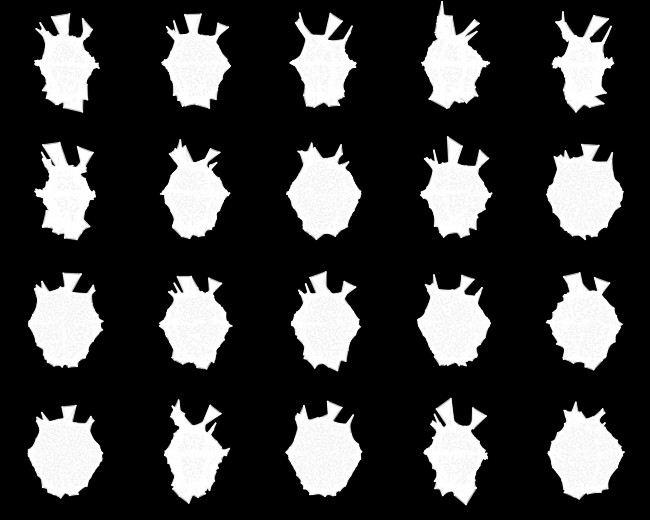


13 3.570267286300659 0.009643006399273872


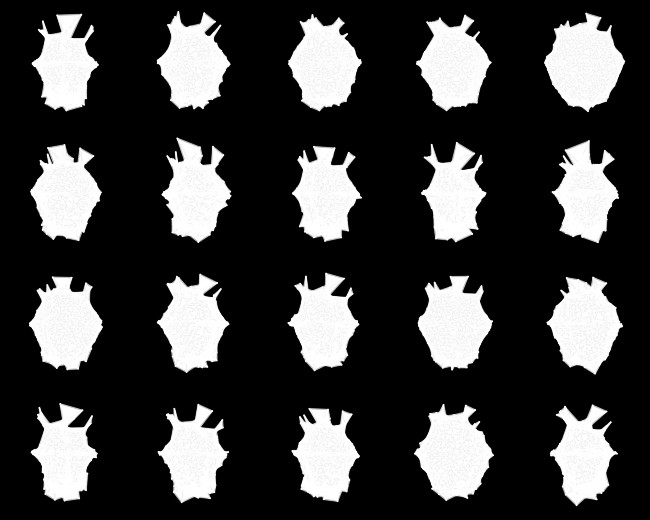


14 3.6326880073547363 0.011398956775665284


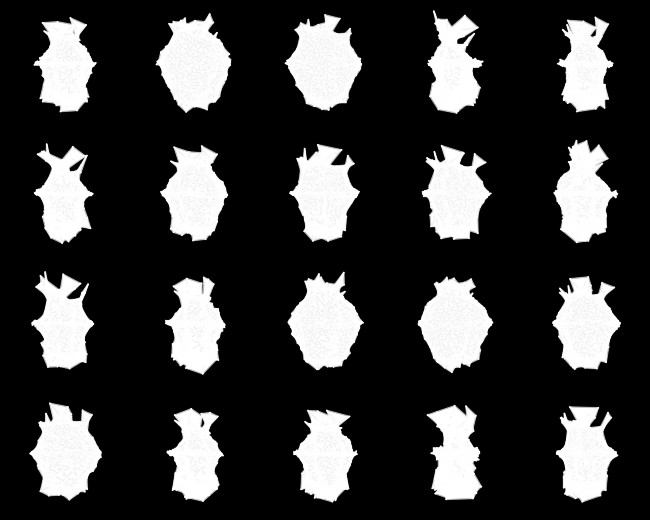


15 3.6636978912353517 0.01255109291523695


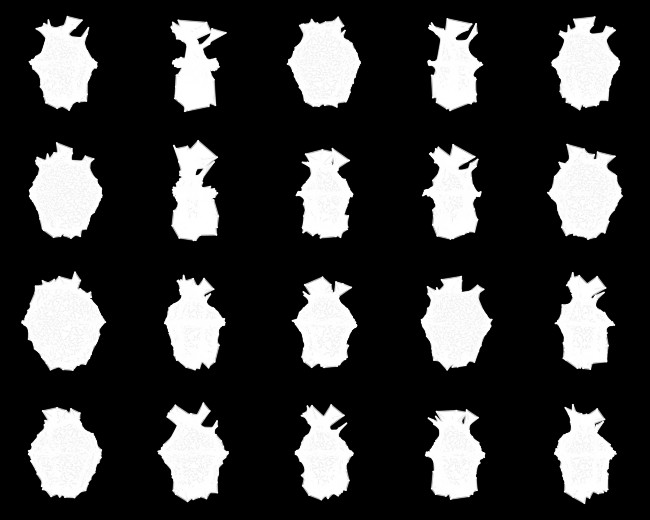


16 3.4860453701019285 0.009645361714065074


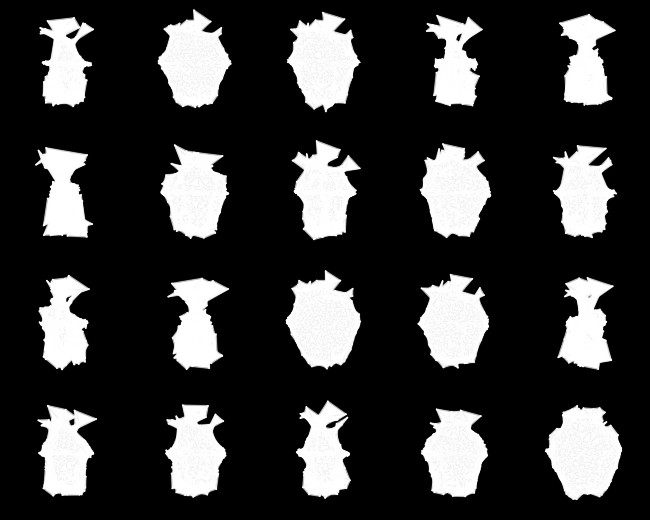


17 2.9480539035797118 0.013798197507858276


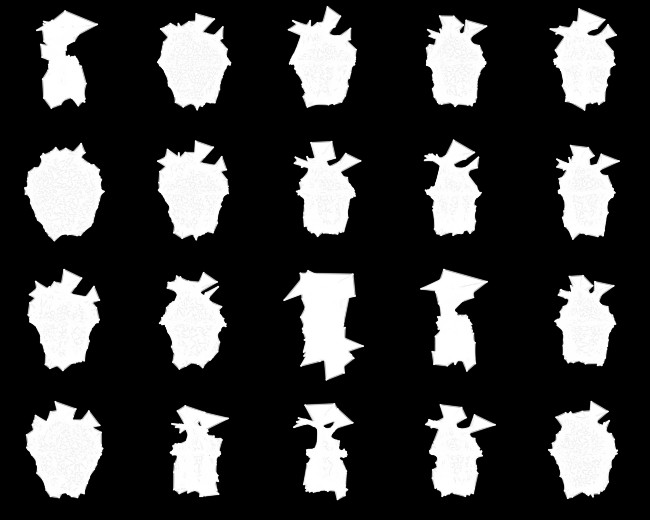


18 2.2925926566123964 0.11531776815652847


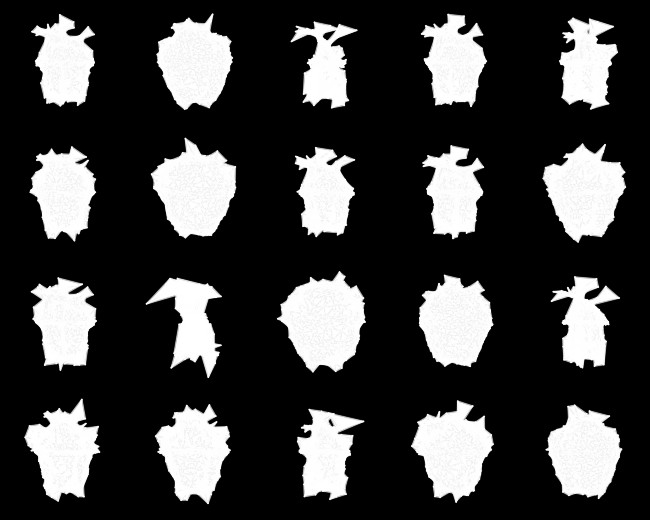


19 2.100948257446289 0.06958188205957412


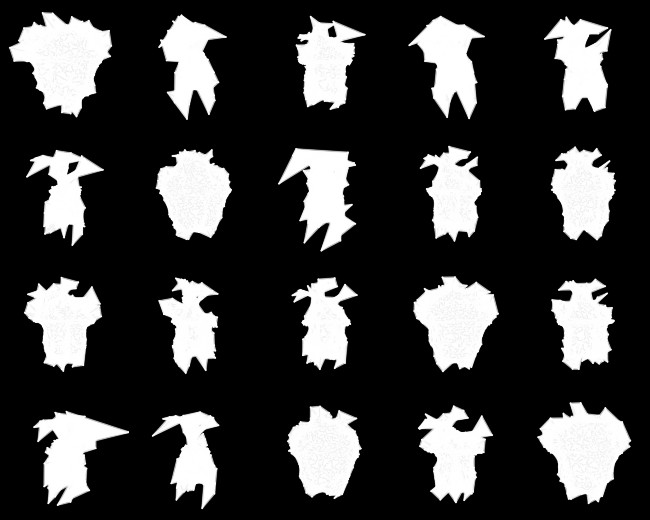


20 1.9522649669647216 0.07850516617298126


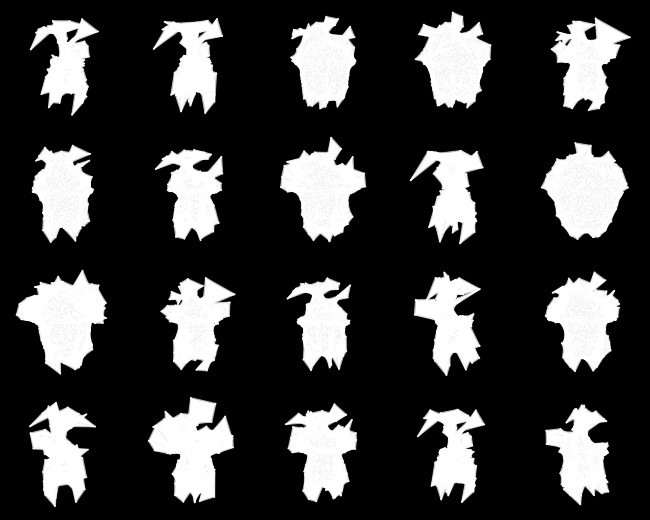


21 1.80848219871521 0.08778496384620667


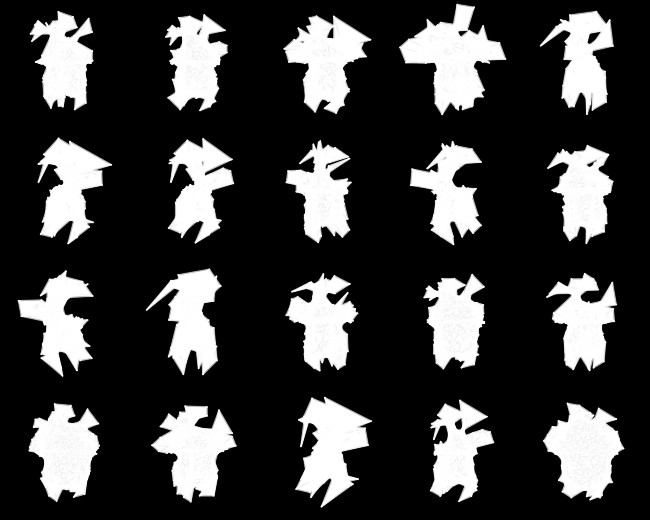


22 1.7253328895568847 0.06034992203116417


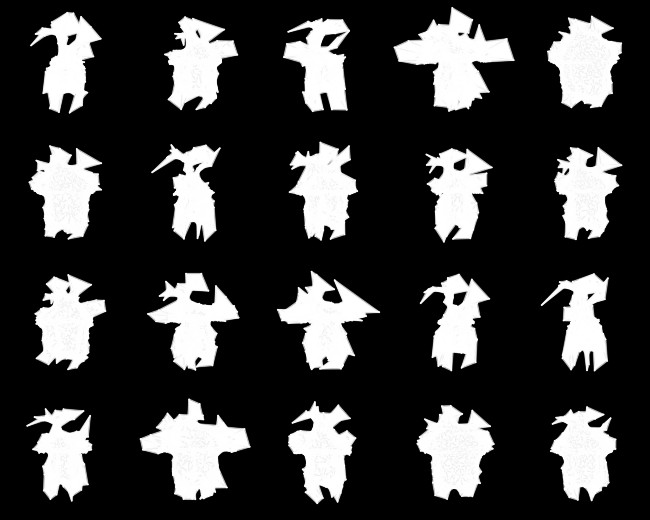


23 1.781285481452942 0.04958449780941009


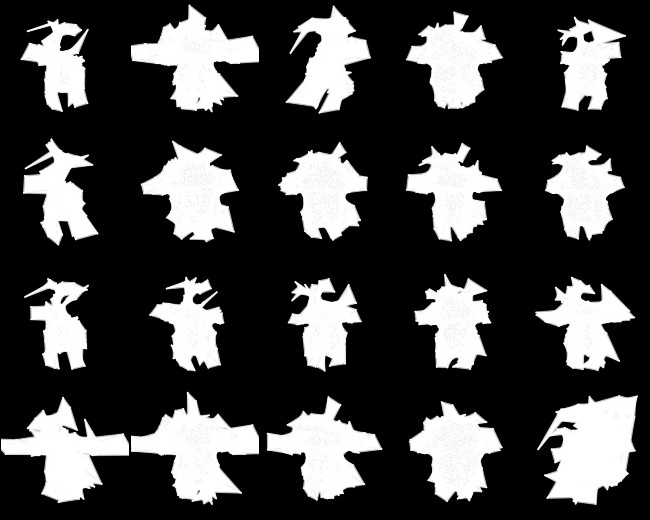


24 1.7788590717315673 0.040218676626682284


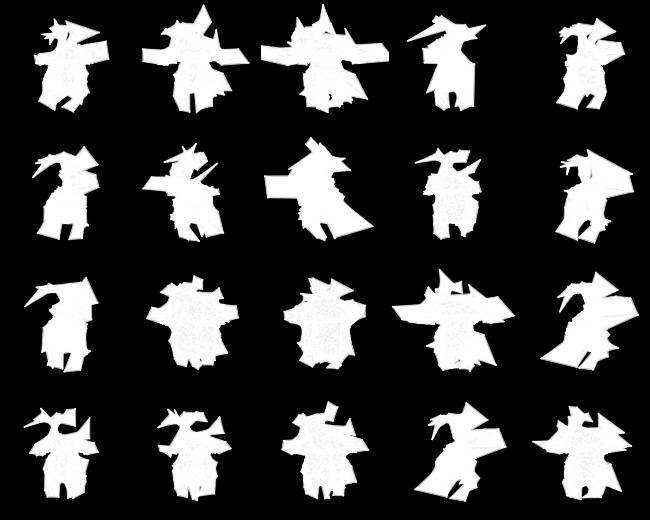


25 1.8910931873321533 0.036586950570344924


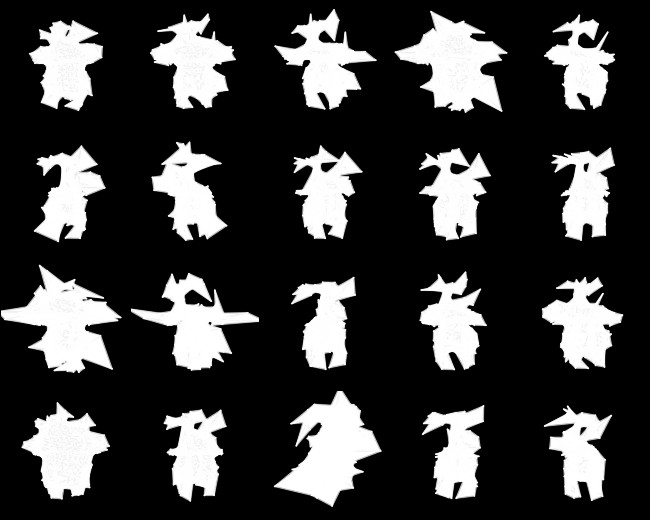


26 1.9810329818725585 0.029883304312825203


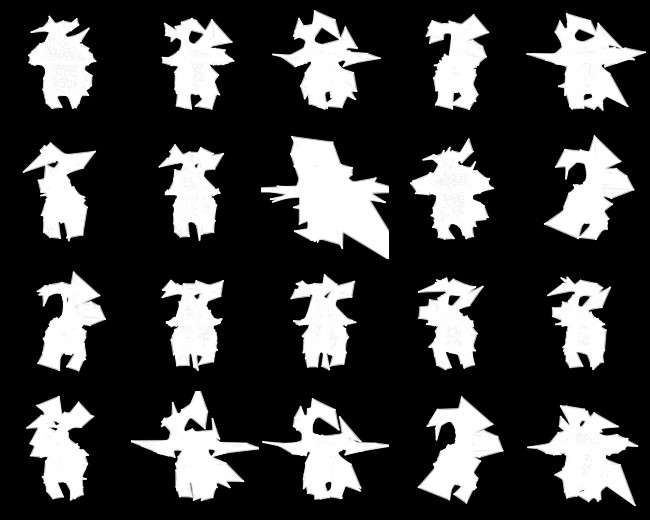


27 1.9377852511405944 0.05128208212554455


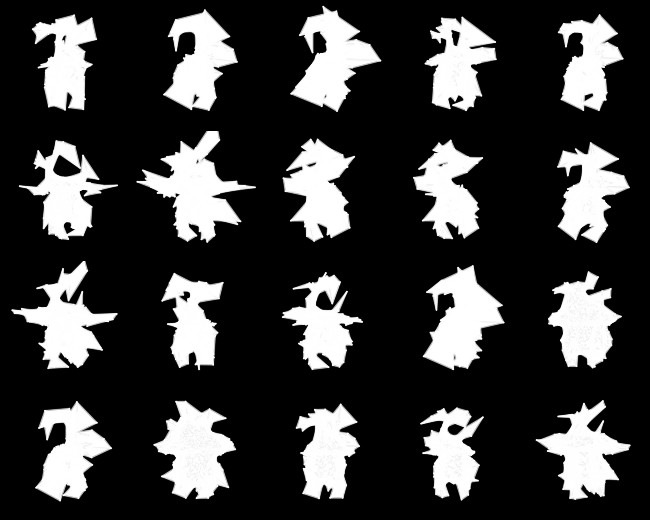


28 2.1103948879241945 0.021775915026664733


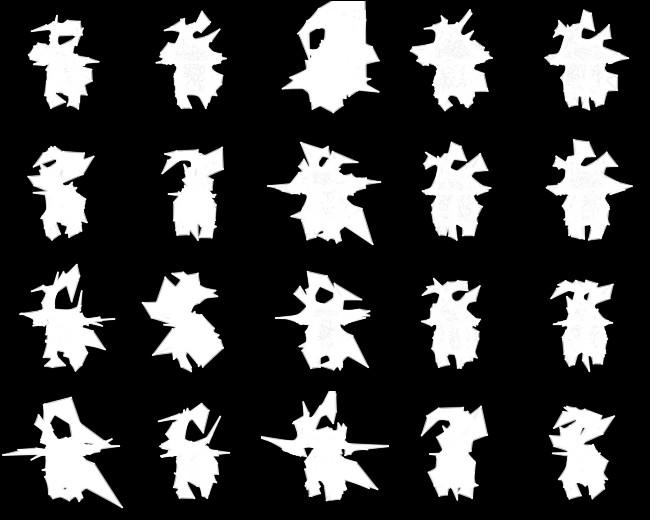


29 1.9714907360076905 0.022838901430368423


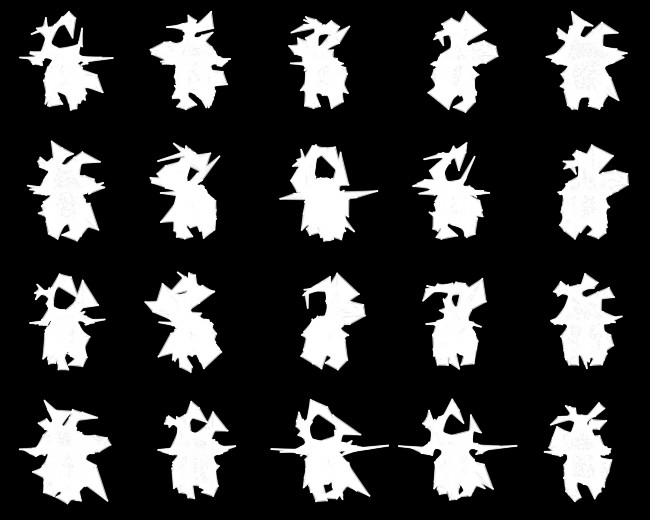


30 1.8659369325637818 0.02100820802152157


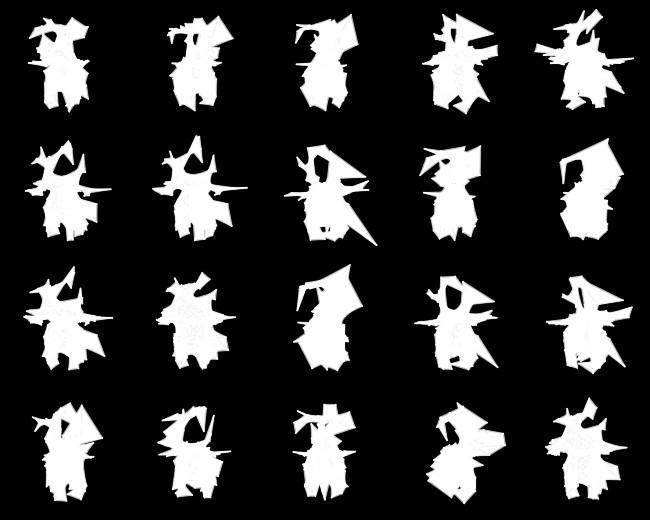


31 1.7701771926879883 0.021126485168933867


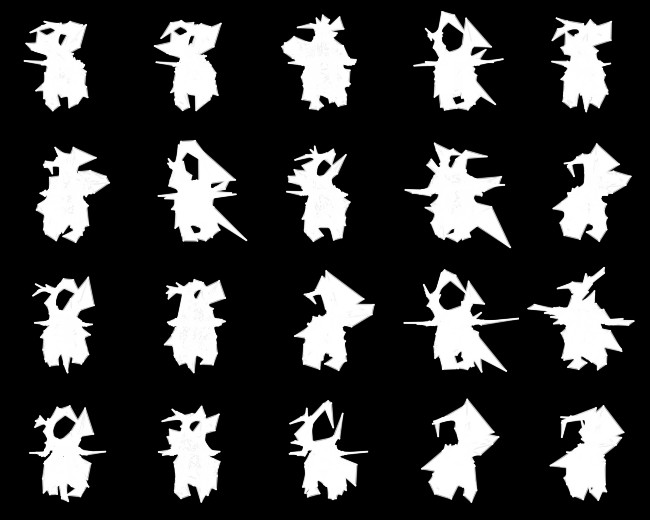


32 1.8088973331451417 0.02190958075225353


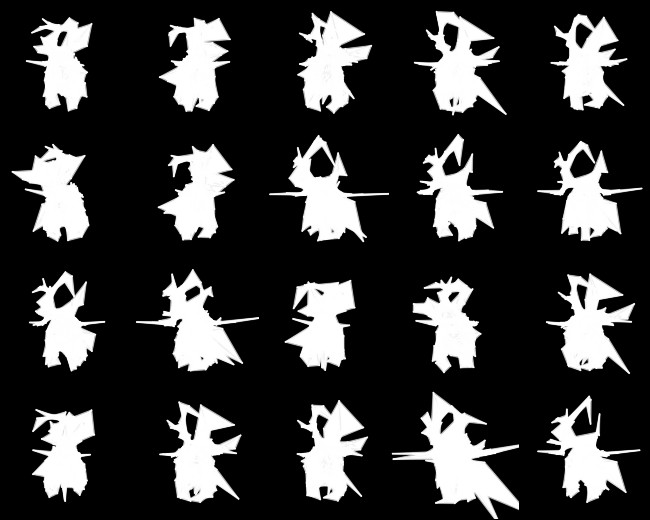


33 1.848367280960083 0.019568451568484305


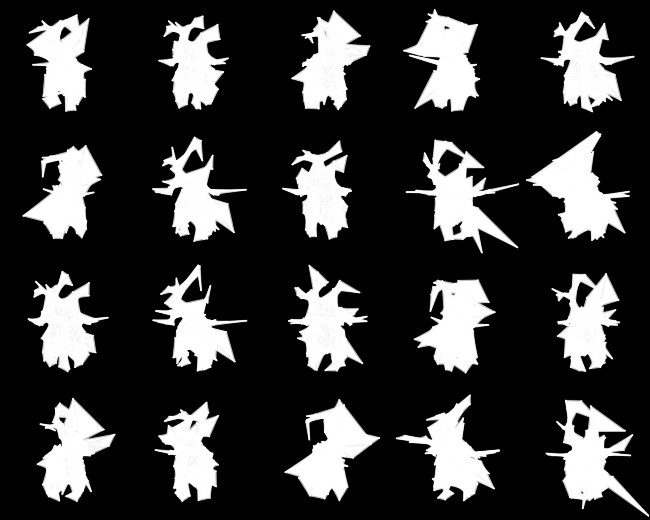


34 1.8977525186538697 0.018108218535780908


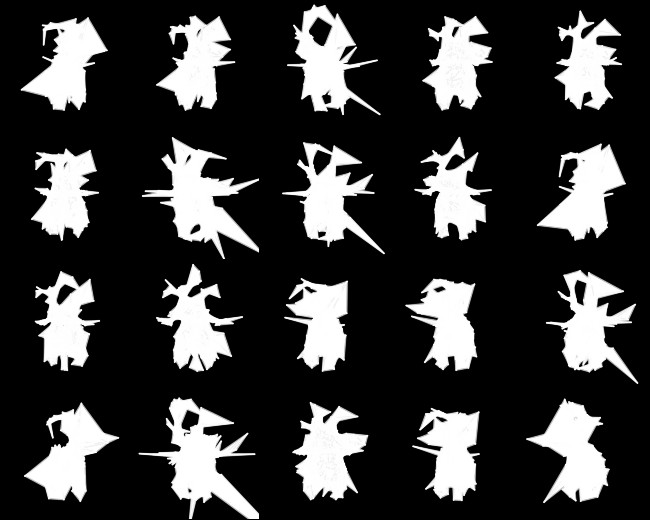


35 1.8897473192214966 0.018639830127358436


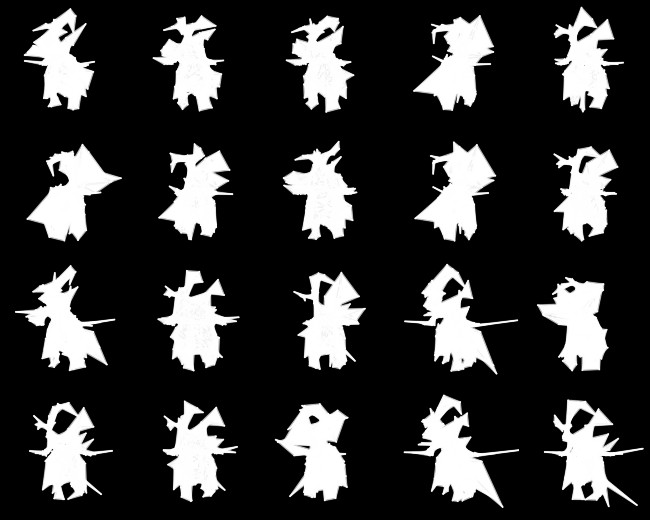


36 1.8375841236114503 0.020884723328053953


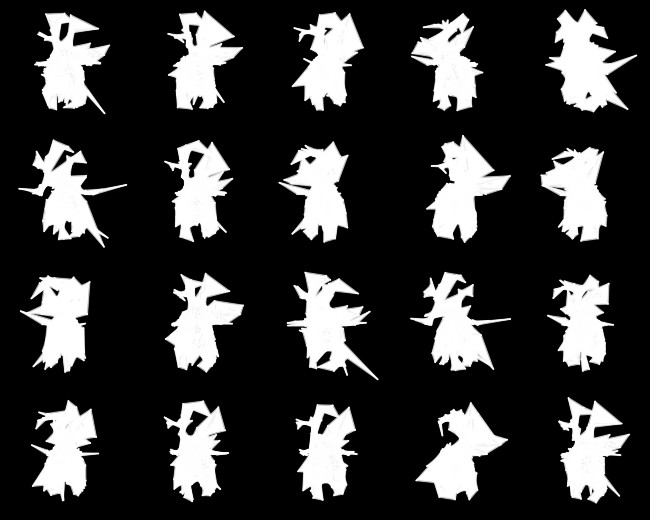


37 1.8690856742858886 0.02098575510084629


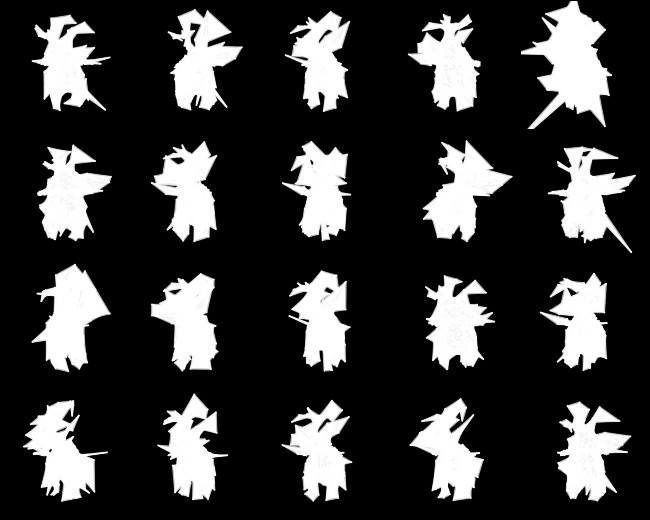


38 1.912717580795288 0.015741763338446617


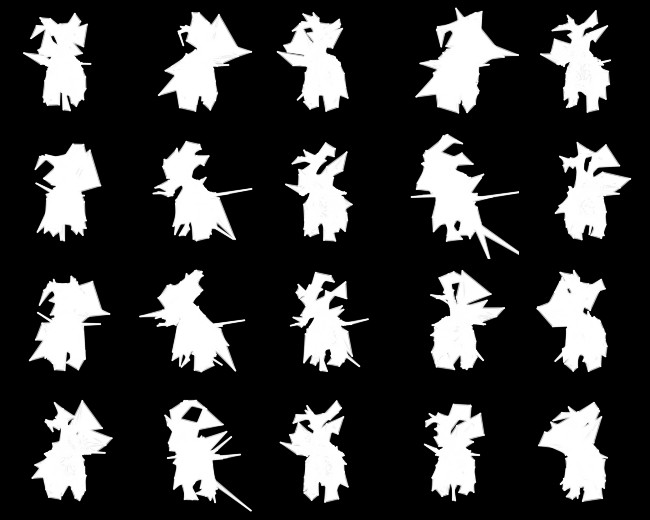


39 1.6036289539933204 0.1382735277712345


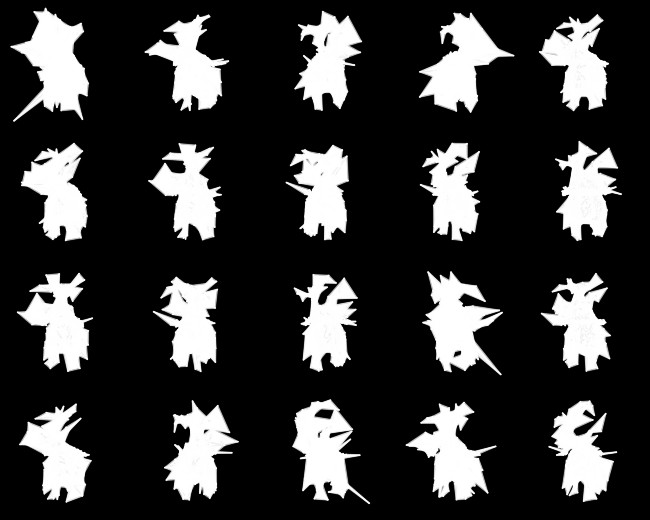


40 1.497976427078247 0.02844885244965553


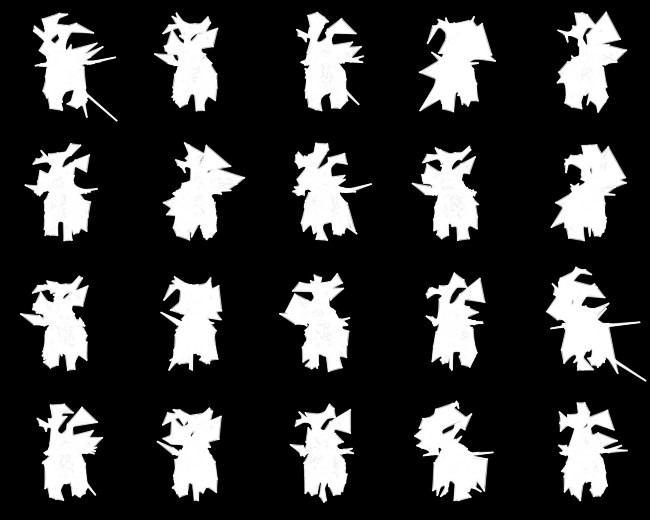


41 1.5689371299743653 0.02597547248005867


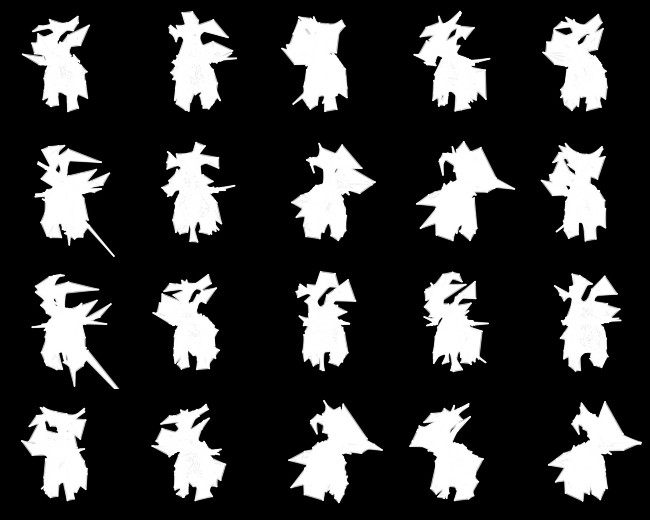


42 1.6091950464248657 0.02287002108991146


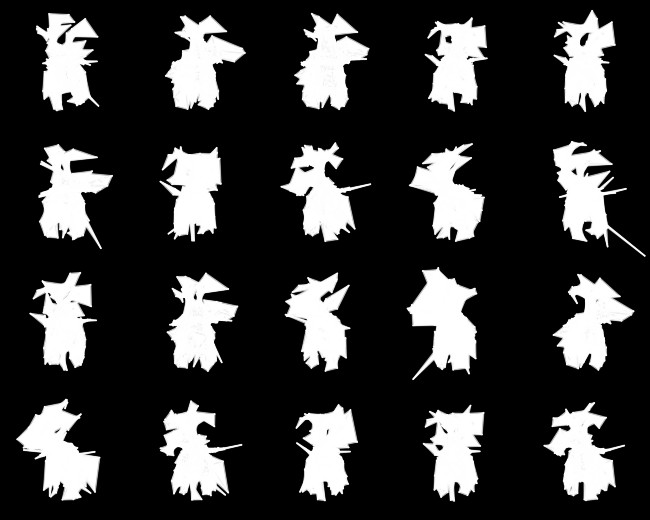


43 1.58698486328125 0.022237236723303796


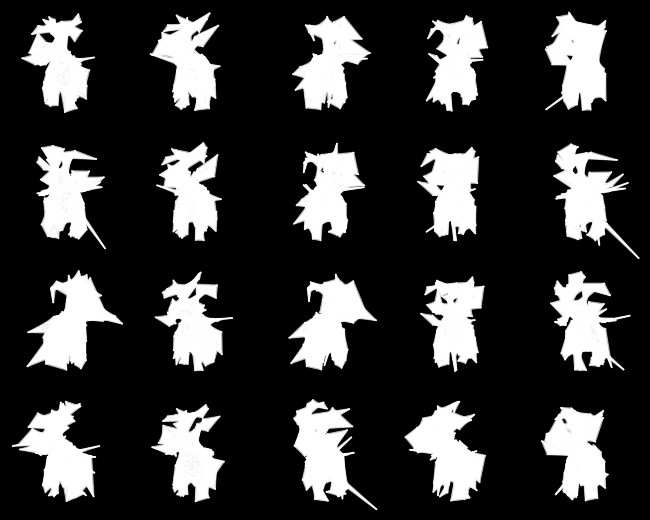


44 1.6248796844482423 0.025959975793957712


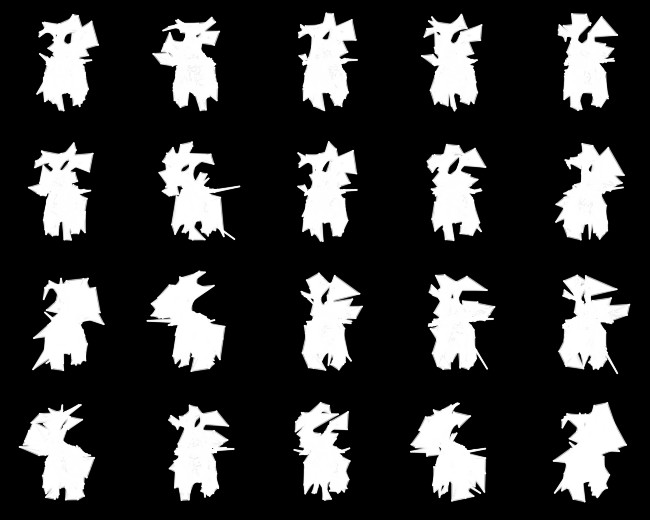


45 1.6600632333755494 0.028437520489096643


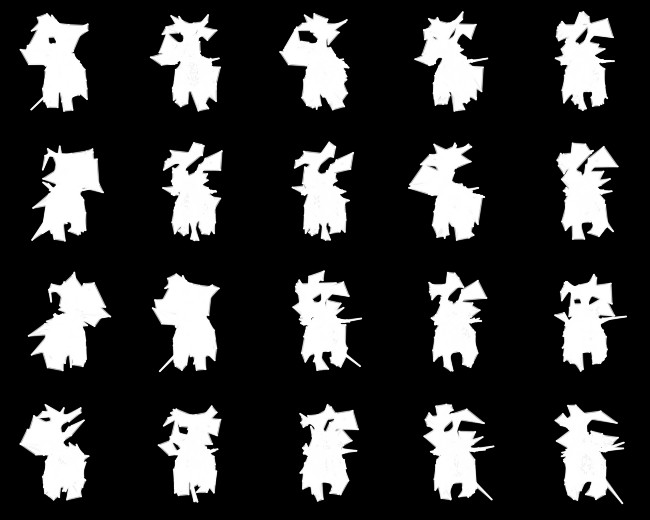


46 1.7278518724441527 0.021225425973534585


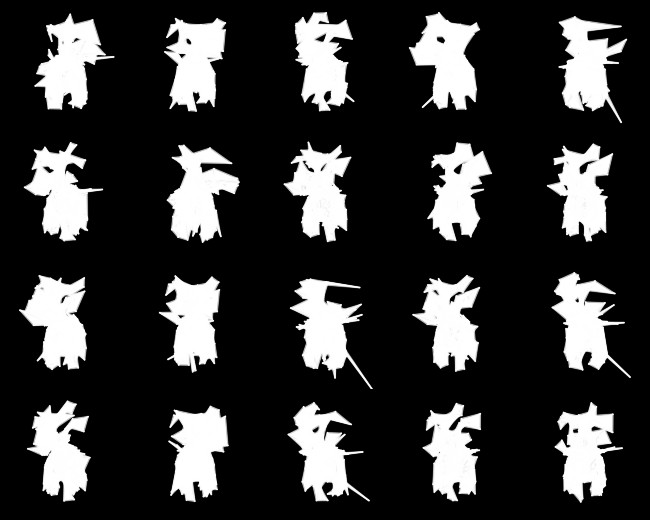


47 1.6968170022964477 0.019782654866576196


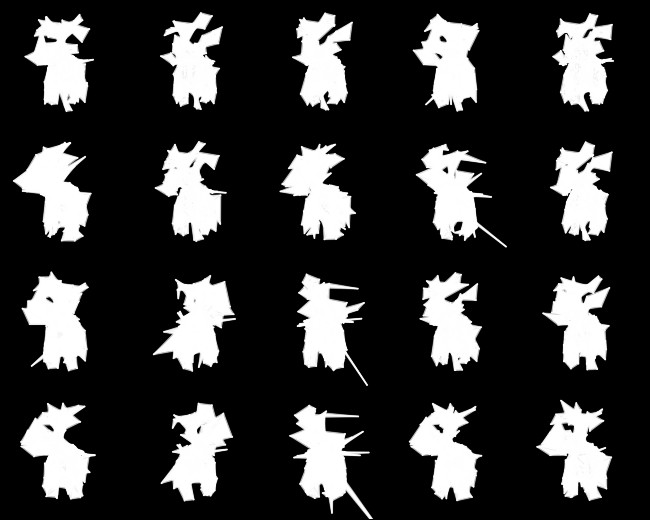


48 1.650627565383911 0.02637765698134899


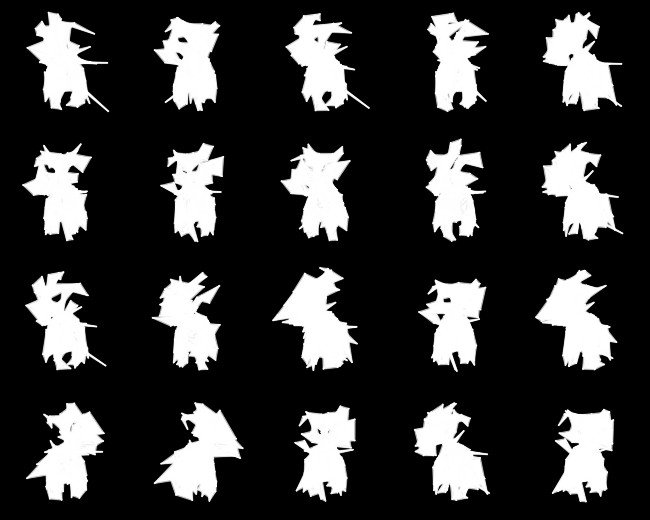


49 1.7316849184036256 0.022530862167477607


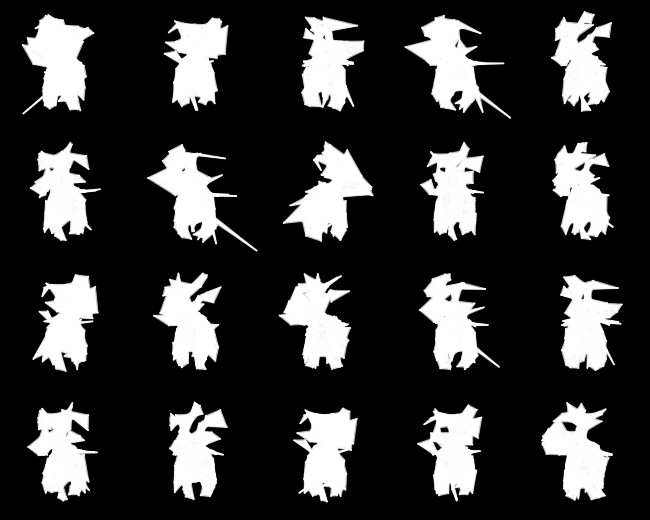

In [73]:
for epoch in range(50):
#     if epoch in [12, 20]:
#         for param_group in optimizer_G.param_groups:
#             param_group['lr'] /= 3
#         for param_group in optimizer_D.param_groups:
#             param_group['lr'] /= 3
    train(epoch)
    display_test()

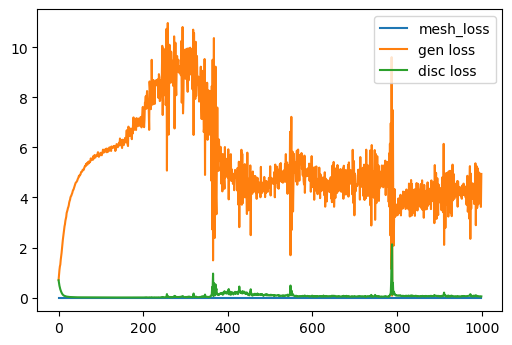

In [74]:
losses_a = np.array(losses).T
_= plt.plot(losses_a[0], label='mesh_loss')
_= plt.plot(losses_a[1], label='gen loss')
_= plt.plot(losses_a[2], label='disc loss')
_= plt.legend()

In [75]:
test_z = torch.randn(batch_size, latent_size).cuda()
gen_mesh, gen_imgs = generator(test_z)

In [67]:
# draw_tensor(gen_imgs, 50)

In [68]:
# draw_tensor(target_hand_silhouette)

In [69]:
from pytorch3d.io import load_objs_as_meshes, save_obj
final_verts, final_faces = gen_mesh[3].get_mesh_verts_faces(0)
final_obj = os.path.join('./', 'gan_export_19.obj')
save_obj(final_obj, final_verts, final_faces)